In [1]:
import time
import pandas as pd 

from random import uniform 
import matplotlib.pyplot as plt
from pulp import *

from utils.distance import haversine_np
from utils.visualization import plot_map

In [2]:
# PARAMETERS

N_TRUCKS = 100 
N_LOADS = 100 

In [3]:
# create truck and load data

trucks = pd.DataFrame(columns = ['lat', 'lon', 'etd'])
loads = pd.DataFrame(columns = ['lat', 'lon', 'closing_time'])

trucks['lon'] = [uniform(0, 1) for _ in range(N_TRUCKS)]
trucks['lat'] = [uniform(0, 1) for _ in range(N_TRUCKS)]
trucks['etd'] = [None for _ in range(N_TRUCKS)]
trucks.reset_index(inplace = True)

loads['lon'] = [uniform(0, 1) for _ in range(N_LOADS)]
loads['lat'] = [uniform(0, 1) for _ in range(N_LOADS)]
loads['closing_time'] = [None for _ in range(N_LOADS)]
loads.reset_index(inplace = True)



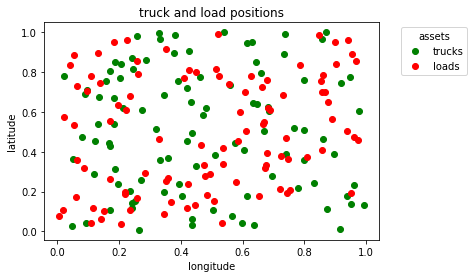

In [4]:
plt.plot(trucks['lon'], trucks['lat'], 'go')
plt.plot(loads['lon'], loads['lat'], "ro")
plt.title('truck and load positions')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(['trucks', 'loads'], title = 'assets', bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.show()

## setup routes 


In [5]:
# routes are the cartesian product trucks x loads 
routes = trucks.add_prefix('truck_').assign(key = 1).merge(
    loads.add_prefix('load_').assign(key = 1), 
    how = 'inner', 
    left_on = 'key',
    right_on = 'key')
routes.drop('key', axis = 1, inplace = True)

# add distance 
routes['distance'] = haversine_np(routes['truck_lon'], routes['truck_lat'], routes['load_lon'], routes['load_lat'])

# create route id 
routes.set_index(['truck_index', 'load_index'], inplace = True)

# show sample
routes.head()

truck_lat  truck_lon truck_etd  load_lat  load_lon  \
truck_index load_index                                                       
0           0            0.989808   0.736847      None  0.213289  0.721009   
            1            0.989808   0.736847      None  0.700669  0.867025   
            2            0.989808   0.736847      None  0.476424  0.961619   
            3            0.989808   0.736847      None  0.102032  0.152332   
            4            0.989808   0.736847      None  0.809388  0.424932   

                       load_closing_time    distance  
truck_index load_index                                
0           0                       None   86.308688  
            1                       None   35.236261  
            2                       None   62.277361  
            3                       None  118.115287  
            4                       None   40.038657

## Create Milp Model

In [6]:
# save start time
start = time.time()

# set really big negativ number
M = -10000

# setup milp
prob = LpProblem("Truck_Assignment_Problem", LpMinimize)
# create decision variables
route_ids = list(routes.index)
decision_vars = LpVariable.dicts('truck', route_ids, cat='Binary')

# create objective function
prob += lpSum([(M+routes.at[idx, 'distance'])*decision_vars[idx] for idx in route_ids]), "Total_Cost_of_Assignments"

# create constraints 
for truck_id in range(len(trucks)):
    prob += lpSum([decision_vars[asgmt] for asgmt in route_ids if asgmt[0] == truck_id]) <= 1, f'max_assignments_truck_{truck_id}'

for load_id in range(len(loads)):
    prob += lpSum([decision_vars[asgmt] for asgmt in route_ids if asgmt[1] == load_id]) <= 1, f'max_assignments_load_{load_id}'

print(f'setup optimization model successful \nruntime {time.time()-start}')

setup optimization model successful 
runtime 0.5007047653198242


# Solve Assignment problem

In [7]:
start = time.time()

prob.solve(PULP_CBC_CMD(msg=0))

print(f'solution status {LpStatus[prob.sol_status]} \nruntime {time.time()-start}')

solution status Optimal 
runtime 0.5054202079772949


# Collect Results

In [11]:
# filter routes 
assignments = routes.loc[[asmgt for asmgt in decision_vars if decision_vars[asmgt].varValue > 0]]

print(f'total cost of assignments {assignments["distance"].sum()}')
print(f'average cost of assignments {assignments["distance"].mean()}')
print(f'number of assignments {len(assignments)} \nnumber of available trucks {len(trucks)} \nnumber of available loads {len(loads)}')
assignments.head()

total cost of assignments 1137.5021176547878
average cost of assignments 11.375021176547877
number of assignments 100 
number of available trucks 100 
number of available loads 100


,,truck_lat,truck_lon,truck_etd,load_lat,load_lon,load_closing_time,distance
truck_index,load_index,,,,,,,
0,63,0.989808,0.736847,None,0.983557,0.847880,None,12.356309
1,47,0.519058,0.767185,None,0.468592,0.739254,None,6.409523
2,71,0.711081,0.095853,None,0.706209,0.096296,None,0.543654
3,14,0.645899,0.633263,None,0.683827,0.730239,None,11.570669
4,12,0.734261,0.558554,None,0.727158,0.663149,None,11.648957


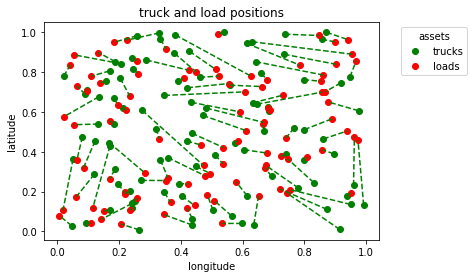

In [10]:
plt.plot(trucks['lon'], trucks['lat'], 'go')
plt.plot(loads['lon'], loads['lat'], "ro")
for _, asgmt in assignments.iterrows():
    x_points = [asgmt['truck_lon'], asgmt['load_lon']]
    y_points = [asgmt['truck_lat'], asgmt['load_lat']]
    plt.plot(x_points, y_points, 'g--')
plt.title('truck and load positions')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(['trucks', 'loads'], title = 'assets', bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.show()